In [ ]:
# pip install py2neo

## Test Data Preprocessing

In [140]:
import pandas as pd
import os
import json
import numpy as np
from sklearn.metrics import roc_auc_score

## Symptoms extracted files
directory_path = 'samples_latest'
data = []

for filename in os.listdir(directory_path):
    if filename.endswith('.json'):
        file_path = os.path.join(directory_path, filename)
        
        with open(file_path, 'r') as file:
            file_data = json.load(file)
            data.append(file_data)

symptoms_df = pd.DataFrame(data)
test_df = pd.read_csv('DIA_GROUPS_3_DIGITS_adm_test.csv')
merged_df = pd.merge(symptoms_df, test_df, how='inner', on='id')
merged_df.head(3)

,Symptoms,Diseases,id,icd_9_desc,text,long_texts,short_texts,discharge_summary,short_codes
0,"[chest tightness, palpitations, ventricular ec...","[aortic valve fibroelastoma, GERD, Basal Cell ...",109136,"Benign neoplasm of heart,Obesity, unspecified,...",CHIEF COMPLAINT: known aortic valve fibroelast...,"Benign neoplasm of heart,Obesity, unspecified,...","Benign neoplasm heart,Obesity NOS,Angina pecto...",Admission Date: [**2149-11-19**] ...,"2127,27800,4139,2859,53081,V1083,28860,V8533"
1,"[intermittent L-sided chest pressure, anterior...","[prostate ca s/p brachytherapy, PVD, h/o pancr...",193197,"True posterior wall infarction, initial episod...",CHIEF COMPLAINT: intermittent L-sided chest pr...,"True posterior wall infarction, initial episod...","True post infarct, init,Ac posthemorrhag anemi...",Admission Date: [**2144-2-23**] ...,"41061,2851,41401,4439,V1046,25000"
2,"[palpitations, dizziness, shortness of breath,...","[mitral regurgitation, mitral stenosis, hypert...",157736,"Mitral stenosis with insufficiency,Other chron...",CHIEF COMPLAINT: mitral regurgitation/stenosis...,"Mitral stenosis with insufficiency,Other chron...","Mitral stenosis w insuff,Chr pulmon heart dis ...",Admission Date: [**2197-10-10**] ...,"3942,4168,27800,42731,311,4019,24200"


In [141]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Symptoms           2686 non-null   object
 1   Diseases           2686 non-null   object
 2   id                 2686 non-null   int64 
 3   icd_9_desc         2686 non-null   object
 4   text               2686 non-null   object
 5   long_texts         2686 non-null   object
 6   short_texts        2686 non-null   object
 7   discharge_summary  2686 non-null   object
 8   short_codes        2686 non-null   object
dtypes: int64(1), object(8)
memory usage: 189.0+ KB


In [142]:
list(merged_df.iloc[1].Symptoms), merged_df.iloc[1].short_codes.split(',')

(['intermittent L-sided chest pressure',
  'anterior wall chest tightness',
  'SOB',
  'left arm paresthesias',
  'hypertensive',
  'nausea',
  'vomiting',
  'diaphoresis',
  'lightheadedness',
  'dizziness',
  'recurring CP',
  'vagal episode with?apnea-->bagged',
  'chronic hip pain'],
 ['41061', '2851', '41401', '4439', 'V1046', '25000'])

### KG RAG

In [144]:
import os
from py2neo import Graph
from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage
from neo4j import GraphDatabase
from dotenv import load_dotenv
import json


uri = "neo4j://localhost:7687" 
auth = ("neo4j", "neo4j_pass3")

driver = GraphDatabase.driver(uri, auth=auth) 
driver.verify_connectivity()

with open('train_dict.json', 'r') as file:
    data = file.read()  # Read the content of the file

# Parse the JSON data
parsed_data = json.loads(data)

result = {}

for key, values in parsed_data.items():
    filtered_diseases = {}
    for value in values:
        disease_code = value['disease_code'].strip()
        disease_desc = value['short_title'].strip()
        
        if disease_code not in filtered_diseases :
            filtered_diseases[disease_code] = {
                'disease_code': disease_code,
                'disease_desc': disease_desc,
                'pos_weight': value['weight']
            }
    
    result[key] = list(filtered_diseases.values())

with open('output_train.json', 'w') as f:
    json.dump(result, f, indent=4)

### Graph Creation

In [6]:
# from tqdm import tqdm

# def create_graph(result):
#     with driver.session() as session:
#         for symptom, diseases in tqdm(result.items()):
#             for disease in diseases:
#                 try:
#                     # Extract attributes from disease data
#                     disease_code = disease['disease_code']
#                     disease_desc = disease['disease_desc']
#                     euclidean_distance = float(disease['euclidean_distance'])
#                     pos_weight = int(disease['pos_weight'])
                    
#                     # Create or update Symptom node
#                     session.run("MERGE (s:Symptom {name: $name})", name=symptom)
                    
#                     # Create or update Disease node with attributes
#                     session.run("""
#                         MERGE (d:Disease {name: $name})
#                         ON CREATE SET d.disease_code = $disease_code, d.description = $description
#                         ON MATCH SET d.disease_code = $disease_code, d.description = $description
#                     """, name=disease['disease_code'], disease_code=disease_code, description=disease_desc)
                    
#                     # Create or update the relationship with attributes
#                     session.run("""
#                         MATCH (s:Symptom {name: $symptom}), (d:Disease {name: $disease_code})
#                         MERGE (s)-[r:ASSOCIATED_WITH]->(d)
#                         ON CREATE SET r.euclidean_distance = $euclidean_distance, r.pos_weight = $pos_weight
#                         ON MATCH SET r.euclidean_distance = $euclidean_distance, r.pos_weight = $pos_weight
#                     """, symptom=symptom, disease_code=disease_code, euclidean_distance=euclidean_distance, pos_weight=pos_weight)
#                 except Exception as e:
#                     print(f"An error occurred: {e}")

# create_graph(result)


### Query

In [146]:
def count_distinct_disease_codes():
    with driver.session() as session:
        result = session.run("""
            MATCH (d:Disease)
            RETURN COUNT(DISTINCT d.short_code) AS distinct_disease_count
        """)
        count = result.single()["distinct_disease_count"]
        return count


distinct_disease_count = count_distinct_disease_codes()
print(f"Number of distinct disease codes in the knowledge graph : {distinct_disease_count}")

Number of distinct disease codes in the knowledge graph : 5889


In [147]:
def get_distinct_disease_codes():
    with driver.session() as session:
        result = session.run("""
            MATCH (d:Disease)
            RETURN DISTINCT d.short_code AS disease_code
        """)
        codes = [record["disease_code"] for record in result]
        return codes

distinct_disease_codes = get_distinct_disease_codes()
print(f"Distinct disease codes in the knowledge graph: {distinct_disease_codes}")


Distinct disease codes in the knowledge graph: ['41011', '42821', '9971', '4271', '41401', '4280', '42731', '45829', '0389', '78552', '5761', '57431', '2930', '70705', '99592', '40390', '2724', '25000', '5859', '49390', '2809', 'V5861', '41412', '78551', '99702', '4275', '5845', '99811', '2869', '43411', '41091', '27800', '03842', '5770', '51881', '5849', '5070', '4019', '2948', '2749', '2859', '82021', '496', '35800', '5990', '2800', '4111', '2449', '41071', '99662', '2767', '40391', '5180', '71101', '2763', '29181', '42820', '4254', '30391', '79029', '42843', 'E9342', '311', 'V7281', '79092', '56400', 'V173', 'V1582', '42090', '5121', '5119', '4168', '78791', 'V5332', 'E8798', '2738', '44020', '4148', 'V4582', '7078', '48241', '4240', '2720', 'V4581', '4139', '53081', '25083', '5771', '5856', '78065', '25063', '3572', 'V4511', '42822', '412', 'V4502', '4142', '32723', '3004', '25060', '71941', '58881', '1970', '2630', '2662', '5768', '73300', '4589', 'V1004', 'V0991', 'E8782', '431',

In [148]:
distinct_symptoms = set(result.keys())

print(len(distinct_symptoms))

39951


In [149]:
codes_ddf = merged_df.assign(short_codes=merged_df['short_codes'].str.split(',')).explode('short_codes').reset_index(drop =True)
codes_ddf = codes_ddf[codes_ddf['short_codes'].apply(len) > 1]
codes_ddf.head()



,Symptoms,Diseases,id,icd_9_desc,text,long_texts,short_texts,discharge_summary,short_codes
0,"[chest tightness, palpitations, ventricular ec...","[aortic valve fibroelastoma, GERD, Basal Cell ...",109136,"Benign neoplasm of heart,Obesity, unspecified,...",CHIEF COMPLAINT: known aortic valve fibroelast...,"Benign neoplasm of heart,Obesity, unspecified,...","Benign neoplasm heart,Obesity NOS,Angina pecto...",Admission Date: [**2149-11-19**] ...,2127
1,"[chest tightness, palpitations, ventricular ec...","[aortic valve fibroelastoma, GERD, Basal Cell ...",109136,"Benign neoplasm of heart,Obesity, unspecified,...",CHIEF COMPLAINT: known aortic valve fibroelast...,"Benign neoplasm of heart,Obesity, unspecified,...","Benign neoplasm heart,Obesity NOS,Angina pecto...",Admission Date: [**2149-11-19**] ...,27800
2,"[chest tightness, palpitations, ventricular ec...","[aortic valve fibroelastoma, GERD, Basal Cell ...",109136,"Benign neoplasm of heart,Obesity, unspecified,...",CHIEF COMPLAINT: known aortic valve fibroelast...,"Benign neoplasm of heart,Obesity, unspecified,...","Benign neoplasm heart,Obesity NOS,Angina pecto...",Admission Date: [**2149-11-19**] ...,4139
3,"[chest tightness, palpitations, ventricular ec...","[aortic valve fibroelastoma, GERD, Basal Cell ...",109136,"Benign neoplasm of heart,Obesity, unspecified,...",CHIEF COMPLAINT: known aortic valve fibroelast...,"Benign neoplasm of heart,Obesity, unspecified,...","Benign neoplasm heart,Obesity NOS,Angina pecto...",Admission Date: [**2149-11-19**] ...,2859
4,"[chest tightness, palpitations, ventricular ec...","[aortic valve fibroelastoma, GERD, Basal Cell ...",109136,"Benign neoplasm of heart,Obesity, unspecified,...",CHIEF COMPLAINT: known aortic valve fibroelast...,"Benign neoplasm of heart,Obesity, unspecified,...","Benign neoplasm heart,Obesity NOS,Angina pecto...",Admission Date: [**2149-11-19**] ...,53081


In [150]:
codes_ddf.short_codes.nunique()

2658

In [151]:
codes_ddf.columns = ['Symptoms', 'Diseases', 'id', 'icd_9_desc', 'text', 'long_texts',
       'short_texts', 'discharge_summary', 'SHORT_CODE']

In [152]:
codes_ddf.loc[
    codes_ddf['SHORT_CODE'].str.startswith("V"), 'SHORT_CODE'] = codes_ddf.SHORT_CODE.apply(
    lambda x: x[:4])
codes_ddf.loc[
    codes_ddf['SHORT_CODE'].str.startswith("E"), 'codes_ddf'] = codes_ddf.SHORT_CODE.apply(
    lambda x: x[:4])
codes_ddf.loc[(~codes_ddf.SHORT_CODE.str.startswith("E")) & (
    ~codes_ddf.SHORT_CODE.str.startswith("V")), 'SHORT_CODE'] = codes_ddf.SHORT_CODE.apply(
    lambda x: x[:3])

In [179]:
codes_ddf.SHORT_CODE.nunique()

905

In [154]:
distinct_disease_codes_df = pd.DataFrame(distinct_disease_codes, columns=['SHORT_CODE'])


In [155]:
distinct_disease_codes_df.head()

,SHORT_CODE
0,41011
1,42821
2,9971
3,4271
4,41401


In [156]:
distinct_disease_codes_df.loc[
    codes_ddf['SHORT_CODE'].str.startswith("V"), 'SHORT_CODE'] = distinct_disease_codes_df.SHORT_CODE.apply(
    lambda x: x[:4])
distinct_disease_codes_df.loc[
    codes_ddf['SHORT_CODE'].str.startswith("E"), 'codes_ddf'] = distinct_disease_codes_df.SHORT_CODE.apply(
    lambda x: x[:4])
distinct_disease_codes_df.loc[(~distinct_disease_codes_df.SHORT_CODE.str.startswith("E")) & (
    ~distinct_disease_codes_df.SHORT_CODE.str.startswith("V")), 'SHORT_CODE'] = distinct_disease_codes_df.SHORT_CODE.apply(
    lambda x: x[:3])

In [157]:
matching_classes = set(list(distinct_disease_codes_df.SHORT_CODE)).intersection(set(list(codes_ddf.SHORT_CODE)))

In [158]:
len(matching_classes)

833

In [159]:
symptoms_ddf = merged_df.assign(short_codes=merged_df['Symptoms'].str.split(',')).explode('Symptoms').reset_index(drop =True)
symptoms_ddf.Symptoms.nunique()
len(distinct_symptoms.intersection(set(list(symptoms_ddf.Symptoms))))

3113

In [160]:
symptoms_ddf = merged_df.assign(short_codes=merged_df['Symptoms'].str.split(',')).explode('Symptoms').reset_index(drop =True)
symptoms_ddf.Symptoms.nunique()

11637

In [161]:
matching_symptom =  distinct_symptoms.intersection(set(list(symptoms_ddf.Symptoms)))

In [162]:
len(distinct_symptoms.intersection(set(list(symptoms_ddf.Symptoms))))

3113

In [163]:
# df = merged_df.assign(short_codes=merged_df['short_codes'].str.split(',')).explode('short_codes').reset_index(drop =True)
# df.head()
# df= df[df['short_codes'].isin(list(matching_classes))].reset_index()

In [164]:
df = merged_df

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Symptoms           2686 non-null   object
 1   Diseases           2686 non-null   object
 2   id                 2686 non-null   int64 
 3   icd_9_desc         2686 non-null   object
 4   text               2686 non-null   object
 5   long_texts         2686 non-null   object
 6   short_texts        2686 non-null   object
 7   discharge_summary  2686 non-null   object
 8   short_codes        2686 non-null   object
dtypes: int64(1), object(8)
memory usage: 189.0+ KB


In [166]:
# id_counts = df['id'].value_counts()

# ids_with_count_5 = id_counts[id_counts == 5].index

# result_df = df[df['id'].isin(ids_with_count_5)].reset_index()

# result_df.info()
               

In [167]:
result_df_temp = df.assign(symptom=df['Symptoms'].str.split(',')).explode('Symptoms').reset_index(drop =True)

In [168]:
result_df_temp.head()

,Symptoms,Diseases,id,icd_9_desc,text,long_texts,short_texts,discharge_summary,short_codes,symptom
0,chest tightness,"[aortic valve fibroelastoma, GERD, Basal Cell ...",109136,"Benign neoplasm of heart,Obesity, unspecified,...",CHIEF COMPLAINT: known aortic valve fibroelast...,"Benign neoplasm of heart,Obesity, unspecified,...","Benign neoplasm heart,Obesity NOS,Angina pecto...",Admission Date: [**2149-11-19**] ...,"2127,27800,4139,2859,53081,V1083,28860,V8533",NaN
1,palpitations,"[aortic valve fibroelastoma, GERD, Basal Cell ...",109136,"Benign neoplasm of heart,Obesity, unspecified,...",CHIEF COMPLAINT: known aortic valve fibroelast...,"Benign neoplasm of heart,Obesity, unspecified,...","Benign neoplasm heart,Obesity NOS,Angina pecto...",Admission Date: [**2149-11-19**] ...,"2127,27800,4139,2859,53081,V1083,28860,V8533",NaN
2,ventricular ectopy/trigeminy,"[aortic valve fibroelastoma, GERD, Basal Cell ...",109136,"Benign neoplasm of heart,Obesity, unspecified,...",CHIEF COMPLAINT: known aortic valve fibroelast...,"Benign neoplasm of heart,Obesity, unspecified,...","Benign neoplasm heart,Obesity NOS,Angina pecto...",Admission Date: [**2149-11-19**] ...,"2127,27800,4139,2859,53081,V1083,28860,V8533",NaN
3,intermittent L-sided chest pressure,"[prostate ca s/p brachytherapy, PVD, h/o pancr...",193197,"True posterior wall infarction, initial episod...",CHIEF COMPLAINT: intermittent L-sided chest pr...,"True posterior wall infarction, initial episod...","True post infarct, init,Ac posthemorrhag anemi...",Admission Date: [**2144-2-23**] ...,"41061,2851,41401,4439,V1046,25000",NaN
4,anterior wall chest tightness,"[prostate ca s/p brachytherapy, PVD, h/o pancr...",193197,"True posterior wall infarction, initial episod...",CHIEF COMPLAINT: intermittent L-sided chest pr...,"True posterior wall infarction, initial episod...","True post infarct, init,Ac posthemorrhag anemi...",Admission Date: [**2144-2-23**] ...,"41061,2851,41401,4439,V1046,25000",NaN


In [169]:
result_df_temp = result_df_temp[result_df_temp['Symptoms'].isin(list(matching_symptom))].reset_index()
grouped_df = result_df_temp.groupby('id')['Symptoms'].apply(list).reset_index()

grouped_df = grouped_df.drop('Symptoms', axis =1)

In [170]:
result_df = pd.merge(grouped_df, df, how = 'inner', on= 'id')
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2626 entries, 0 to 2625
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 2626 non-null   int64 
 1   Symptoms           2626 non-null   object
 2   Diseases           2626 non-null   object
 3   icd_9_desc         2626 non-null   object
 4   text               2626 non-null   object
 5   long_texts         2626 non-null   object
 6   short_texts        2626 non-null   object
 7   discharge_summary  2626 non-null   object
 8   short_codes        2626 non-null   object
dtypes: int64(1), object(8)
memory usage: 184.8+ KB


In [171]:
result_df.columns = ['id', 'Symptoms', 'Diseases', 'icd_9_desc', 'text', 'long_texts',
       'short_texts', 'discharge_summary', 'SHORT_CODE']

In [172]:
result_df.loc[
    codes_ddf['SHORT_CODE'].str.startswith("V"), 'SHORT_CODE'] = result_df.SHORT_CODE.apply(
    lambda x: x[:4])
result_df.loc[
    codes_ddf['SHORT_CODE'].str.startswith("E"), 'codes_ddf'] = result_df.SHORT_CODE.apply(
    lambda x: x[:4])
result_df.loc[(~result_df.SHORT_CODE.str.startswith("E")) & (
    ~result_df.SHORT_CODE.str.startswith("V")), 'SHORT_CODE'] = result_df.SHORT_CODE.apply(
    lambda x: x[:3])

In [173]:
result_df = result_df.assign(short_codes=result_df['SHORT_CODE'].str.split(',')).explode('SHORT_CODE').reset_index(drop =True)
result_df = result_df[result_df['SHORT_CODE'].apply(len) > 1]

result_df= result_df[result_df['SHORT_CODE'].isin(list(matching_classes))].reset_index()

In [174]:
matching_df= result_df


In [175]:
matching_df.head()

,index,id,Symptoms,Diseases,icd_9_desc,text,long_texts,short_texts,discharge_summary,SHORT_CODE,codes_ddf,short_codes
0,0,100019,"[heart murmur since childhood, increase in the...","[Bicuspid aortic valve, Dilated aorta, Aortic ...","Aortic valve disorders,Congenital insufficienc...",CHIEF COMPLAINT: \n\nPRESENT ILLNESS: The pati...,"Aortic valve disorders,Congenital insufficienc...","Aortic valve disorder,Cong aorta valv insuffic...",Admission Date: [**2138-6-9**] Discharge ...,424,NaN,[424]
1,1,100028,"[Right upper quadrant pain, Fever, Elevated LF...","[Mild mental retardation, Cholangitis, Choledo...","Cholangitis,Unspecified septicemia,Acute edema...",CHIEF COMPLAINT: Right upper quadrant pain\n\n...,"Cholangitis,Unspecified septicemia,Acute edema...","Cholangitis,Septicemia NOS,Acute lung edema NO...",Admission Date: [**2142-12-23**] ...,576,NaN,[576]
2,2,100038,"[dizziness, nausea, vomiting, chest pain, hypo...","[HTN, DM 2, hyperlipidemia, CAD s/p 4V CABG, a...","Hypotension, unspecified,Acute kidney failure,...","CHIEF COMPLAINT: dizziness,nausea,vomiting\n\n...","Hypotension, unspecified,Acute kidney failure,...","Hypotension NOS,Acute kidney failure NOS,Volum...",Admission Date: [**2127-7-11**] ...,458,NaN,[458]
3,3,100058,"[midback pain, severe headache, vomiting, fati...","[ACA aneurysm, intracranial aneurysm, subarach...","Subarachnoid hemorrhage,Hyposmolality and/or h...",CHIEF COMPLAINT: \n\nPRESENT ILLNESS: The pati...,"Subarachnoid hemorrhage,Hyposmolality and/or h...","Subarachnoid hemorrhage,Hyposmolality,Tobacco ...",Admission Date: [**2139-9-8**] Discharge ...,430,NaN,[430]
4,4,100104,"[abdominal pain, nausea, vomiting, diarrhea, f...","[perforated diverticulitis, septic shock, acut...","Unspecified septicemia,Septic shock,Acute vasc...",CHIEF COMPLAINT: Perforated diverticulitis\n\n...,"Unspecified septicemia,Septic shock,Acute vasc...","Septicemia NOS,Septic shock,Ac vasc insuff int...",Admission Date: [**2201-6-21**] ...,038,NaN,[038]


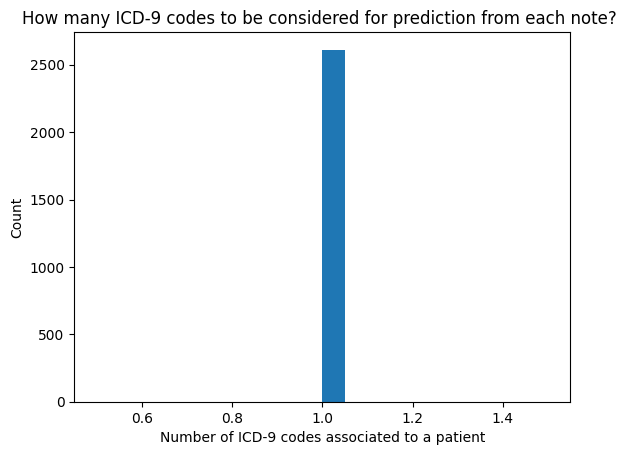

In [178]:
import matplotlib.pyplot as plt
plt.hist(matching_df.id.value_counts(), bins =20)
plt.xlabel('Number of ICD-9 codes associated to a patient')
plt.ylabel('Count')
plt.title('How many ICD-9 codes to be considered for prediction from each note? ')
plt.show()

In [106]:
matching_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27610 entries, 0 to 27609
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   index              27610 non-null  int64 
 1   id                 27610 non-null  int64 
 2   Symptoms           27610 non-null  object
 3   Diseases           27610 non-null  object
 4   icd_9_desc         27610 non-null  object
 5   text               27610 non-null  object
 6   long_texts         27610 non-null  object
 7   short_texts        27610 non-null  object
 8   discharge_summary  27610 non-null  object
 9   SHORT_CODE         27610 non-null  object
 10  codes_ddf          1053 non-null   object
 11  short_codes        27610 non-null  object
dtypes: int64(2), object(10)
memory usage: 2.5+ MB


In [107]:
all_short_codes = set(list(matching_df.SHORT_CODE))
print(f'No. of Short Codes : {len(set(all_short_codes))}')
df_one_hot = pd.get_dummies(matching_df, columns=['SHORT_CODE'])
df_one_hot.columns = df_one_hot.columns.str.replace('SHORT_CODE_', '')
df_one_hot = df_one_hot.drop(['Symptoms', 'Diseases','icd_9_desc', 'text', 'long_texts',
       'short_texts', 'discharge_summary','codes_ddf','short_codes'], axis =1).reset_index(drop=True)
df_one_hot = df_one_hot.astype(int)
df_one_hot.head()

No. of Short Codes : 816


,index,id,005,007,008,011,012,013,027,031,...,V632,V641,V642,V643,V644,V667,V707,V741,V850,V851
0,0,100019,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,100019,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,100019,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,100019,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,100028,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [644]:
# from tqdm import tqdm

# def create_graph(parsed_data):
#     with driver.session() as session:
#         for symptom, diseases in tqdm(parsed_data.items()):
#             for disease in diseases:
#                 try:
#                     # Symptom node
#                     session.run("MERGE (s:Symptom {name: $name})", name=symptom)
                    
#                     # Disease node
#                     session.run("MERGE (d:Disease {name: $name})", name=disease['disease'])
                    
#                     # Create a relationship between the symptom and disease with pos_weight
#                     session.run("""
#                         MATCH (s:Symptom {name: $symptom}), (d:Disease {name: $disease})
#                         MERGE (s)-[r:ASSOCIATED_WITH]->(d)
#                         ON CREATE SET r.pos_weight = $pos_weight
#                         ON MATCH SET r.pos_weight = $pos_weight
#                     """, symptom=symptom, disease=disease['disease'], pos_weight=int(disease['pos_weight']))
#                 except Exception as e:
#                     print(f"An error occurred: {e}")

# create_graph(parsed_data)

In [108]:
def delete_all_data():
    with driver.session() as session:
        session.run("MATCH (n) DETACH DELETE n")
        print("All data has been deleted.")

# delete_all_data()

In [109]:
list(merged_df.iloc[0].Symptoms)

['chest tightness', 'palpitations', 'ventricular ectopy/trigeminy']

In [111]:
def get_prioritized_relationships(symptom_names):
    with driver.session() as session:
        result = session.run("""
            MATCH (s:Symptom)-[r:ASSOCIATED_WITH]->(d:Disease)
            WHERE s.name IN $symptoms
            RETURN s.name AS symptom, d.title AS disease_name, d.short_code AS disease_code, r.weight AS weight
            ORDER BY r.weight DESC
            LIMIT 816
        """, symptoms=symptom_names)
        
        codes = []
        codes_desc = {}
        all_info = {}
        for record in result:
            # Store the disease name and code
            codes.append(f"Disease Name: {record['disease_name']}, ICD-9 code: {record['disease_code']}")
            codes_desc[record['disease_code']] = record['disease_name']
            all_info[record['disease_code']] = [record['disease_name'], record['weight']]
            
        return codes, codes_desc, all_info

In [112]:
def codes_n_desc(list_codes, results) : 
    
    try : 
        five_codes = list_codes[2:-2].split("', '")
    except KeyError as s: 
        five_codes = list_codes[2:-2].split(", ")
    except : 
        
        five_codes = list_codes[2:-2].split('", "')
    
    return [(i,results.get(i)) for i in five_codes]

In [650]:
# def get_prioritized_relationships(symptom_names):
#     with driver.session() as session:
#         result = session.run("""
#             MATCH (s:Symptom)-[r:ASSOCIATED_WITH]->(d:Disease)
#             WHERE s.name IN $symptoms
#             RETURN s.name AS symptom, d.title AS disease_name, d.short_code AS disease_code, r.weight AS weight
#             ORDER BY r.weight DESC
#             LIMIT 50
#         """, symptoms=symptom_names)
        
#         codes = []
#         codes_desc = {}
#         all_info = {}
#         for record in result:
#             # Store the disease name and code
#             codes.append(f"Disease Name: {record['disease_name']}, ICD-9 code: {record['disease_code']}")
#             codes_desc[record['disease_code']] = record['disease_name']
#             all_info[record['disease_code']] = [record['disease_name'], record['weight']]
            
#         return codes, codes_desc, all_info


# def aug_and_gen(codes, symptom) : 
       
# #     kg_prompt = f"""
# # Given list is the most relevant diseases based on the symptom : {symptom}
# #     IMPORTANT : Don't return anything except the python list of ICD-9 codes
# #     IMPORTANT : Make sure the codes are in the provided list
# #     Your task is to use your knowledge base to identify the most relevant disease among them for the given symptom.
# #     Return the top 10 ICD-9 code mentioned in the text for the most relevant disease in python list format :
# #     [disease1_code, disease2_code, disease3_code,...]
# #     - return only the python list of ICD-9 codes, not even description 
# #     - Make sure the codes are in the provided list of disease names and codes
# #     - Don't return anything except the python list of codes
# #     - Return the top 10 ICD-9 code 
# # """
#     prompt_start = """You are an AI assistant tasked with identifying the top 5 most relevant ICD-9 codes for a given symptom, based on a provided list of disease names and codes.
# Symptom: {symptom}"""
#     kg_prompt = """
# Relevant Disease Codes:
# <<<
# [disease1_code, disease2_code, disease3_code,...]
# Output the top 5 most relevant ICD-9 codes in the following format:
# [
# {disease1_code},
# {disease2_code},
# {disease3_code},
# {disease4_code},
# {disease5_code},
# ]
# Return only the Python list of ICD-9 codes, not the descriptions
# Make sure the codes are in the provided list of disease names and codes
# Don't return anything except the Python list of codes
# Return the top 5 most relevant ICD-9 codes"""

#     model= "open-mistral-nemo-2407" 
#     MISTRAL_API_KEY =  "WRhxY4qx7jsun5iYThrdS3Dk4dubsjnV"
#     client = MistralClient(api_key=MISTRAL_API_KEY)

#     prompt_template = prompt_start + kg_prompt + str(codes)

#     chat_response = client.chat(
#         model=model,
#         max_tokens=200,
#         temperature = 0.5,
#         messages=[ChatMessage(role="user", content=prompt_template)])



#     return chat_response.choices[0].message.content

# def codes_n_desc(list_codes, results) : 
    
#     try : 
#         five_codes = list_codes[2:-2].split("', '")
#     except KeyError as s: 
#         five_codes = list_codes[2:-2].split(", ")
#     except : 
        
#         five_codes = list_codes[2:-2].split('", "')
    
#     return [(i,results.get(i)) for i in five_codes]


In [113]:
result_df_temp.Symptoms.nunique()

3113

In [114]:
merged_df = pd.merge(merged_df,grouped_df, how = 'inner', on = 'id')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2626 entries, 0 to 2625
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Symptoms           2626 non-null   object
 1   Diseases           2626 non-null   object
 2   id                 2626 non-null   int64 
 3   icd_9_desc         2626 non-null   object
 4   text               2626 non-null   object
 5   long_texts         2626 non-null   object
 6   short_texts        2626 non-null   object
 7   discharge_summary  2626 non-null   object
 8   short_codes        2626 non-null   object
dtypes: int64(1), object(8)
memory usage: 184.8+ KB


In [116]:
from tqdm import tqdm

rows_codes = {}
not_matching_rows_codes = []
for j,i in tqdm(merged_df.iterrows()) : 
    symptom = list(merged_df.iloc[j].Symptoms)
    underweight, results, all_infos = get_prioritized_relationships(symptom)
    if len(underweight) !=0:
        list_codes = list(get_prioritized_relationships(merged_df.iloc[0].Symptoms)[-1].keys())
        codes_n_descs = list_codes
        # print(codes_n_descs)
        rows_codes[j] = codes_n_descs
    else : 
        print(f'Symptom {symptom} is not in the graph')
        not_matching_rows_codes.append(j)
    if j==100:
        break

  

100it [00:05, 18.30it/s]


In [117]:
len(not_matching_rows_codes)

0

In [118]:
len(rows_codes.keys())

101

## AUROC Calculation

In [119]:
import numpy as np
from sklearn.metrics import roc_auc_score

# True labels (binary encoding)
true_labels = np.array([
    [1, 1, 0, 0, 1, 0, 1, 0],  # Sample 1
    [0, 0, 0, 1, 0, 0, 0, 1],  # Sample 2
    [0, 0, 1, 0, 0, 1, 1, 1],  # Sample 3
])

# Predicted scores (binary encoding)
predicted_scores = np.array([
    [1, 1, 1, 0, 0, 0, 0, 0],  # Sample 1
    [0, 0, 0, 1, 1, 0, 0, 0],  # Sample 2
    [0, 0, 0, 0, 0, 1, 1, 0],  # Sample 3
])

# Calculate AUROC for each class
auroc_scores = []
for i in range(true_labels.shape[1]):
    if len(np.unique(true_labels[:, i])) > 1:  # Ensure the class is present in true labels
        auc = roc_auc_score(true_labels[:, i], predicted_scores[:, i])
        auroc_scores.append(auc)
    else:
        auroc_scores.append(float('nan'))  # Assign NaN if the class is not present

print("AUROC Scores for each class:", auroc_scores)

np.mean(auroc_scores)

AUROC Scores for each class: [1.0, 1.0, 0.25, 1.0, 0.25, 1.0, 0.75, 0.5]


0.71875

In [120]:
# matching_df = matching_df.reset_index()


In [121]:
df_one_hot.head()

,index,id,005,007,008,011,012,013,027,031,...,V632,V641,V642,V643,V644,V667,V707,V741,V850,V851
0,0,100019,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,100019,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,100019,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,100019,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,100028,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
auroc_list =[]
true_array_list = []
predicted_array_list = []
for row_num, predicted_results in tqdm(rows_codes.items()) : 
    predicted_labels = predicted_results
    # Whether predicted labels are there in the mimic test dataset or not
    available_labels = [str(label) for label in predicted_labels if label in list(df_one_hot.columns)]
    # df_one_hot[available_labels]
    ## Creating a new dataframe with all 2k+ classes
    df = pd.DataFrame(columns=list(df_one_hot.columns))
    df.loc[0] = np.zeros(len(df.columns), dtype=int)
    df = df.astype(int)
    ## Adding +1 for the available labels
    columns_to_increment = list(set(available_labels))
    df.loc[0, columns_to_increment] += 1
    # # True labels 
    # y_true = [1, 0, 0]   
    # # Predicted 
    # y_pred_prob = [1, 0,1]
    # # macro-averaged AUROC
    # auroc_macro = roc_auc_score(y_true, y_pred_prob, average='macro', multi_class='ovr')
    # print(f"Macro-Averaged AUROC: {auroc_macro:.3f}")
    ## mimic labels
    true = list(df_one_hot[df_one_hot.index == row_num].iloc[:,2:].values[0])
    
    true_array_list.append(true)
    ## knowledge graph predicted labels
    pred = list(df.iloc[0,2:])
    
    predicted_array_list.append(pred)
    # print(true)
    # print(pred)
    

100%|██████████| 101/101 [00:02<00:00, 34.33it/s]


In [123]:
print(true)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [124]:
print(len(true_array_list)), print(len(predicted_array_list))

101
101


(None, None)

In [125]:
len(true_array_list[0]), len(predicted_array_list[0])

(816, 816)

In [126]:
len(true_array_list)

101

In [127]:
# true_array_list[0]

In [136]:
# distinct_values = [set() for _ in range(len(true_array_list))]

# # Step 2: Iterate through the array list and populate the sets
# for sublist in true_array_list:
#     for idx, value in enumerate(sublist):
#         distinct_values[idx].add(value)


# non_single_value_indices = [idx for idx, value_set in enumerate(distinct_values) if len(value_set) !=1]


# non_single_value_indices

In [139]:
len(true_array_list[3])

816

In [130]:
# tr

In [131]:
index_sum = [0]*len(true_array_list[0])


In [132]:

for i in true_array_list : 
    for j,k in enumerate(i) : 
        index_sum[j] +=k


In [133]:
len([i for i in index_sum if i==0])

751

In [134]:
auroc_macro = roc_auc_score(np.array(true_array_list), np.array(predicted_array_list), average='macro', multi_class='ovr')

print(auroc_macro)

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [290]:
import numpy as np

np.mean(auroc_list)

/Applications/anaconda3/envs/astro/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Applications/anaconda3/envs/astro/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan

In [291]:
np.mean(auroc_list)

nan

In [292]:
df_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 83 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   index   101 non-null    int64
 1   id      101 non-null    int64
 2   03849   101 non-null    int64
 3   04184   101 non-null    int64
 4   2127    101 non-null    int64
 5   24200   101 non-null    int64
 6   2449    101 non-null    int64
 7   25000   101 non-null    int64
 8   2720    101 non-null    int64
 9   2761    101 non-null    int64
 10  2763    101 non-null    int64
 11  2768    101 non-null    int64
 12  27800   101 non-null    int64
 13  2851    101 non-null    int64
 14  2859    101 non-null    int64
 15  2875    101 non-null    int64
 16  28860   101 non-null    int64
 17  29680   101 non-null    int64
 18  311     101 non-null    int64
 19  3159    101 non-null    int64
 20  317     101 non-null    int64
 21  34590   101 non-null    int64
 22  3484    101 non-null    int64
 23  3485    101 non

In [50]:
trueee = list(df_one_hot.iloc[3,1:])

df_one_hot.columns[df_one_hot.iloc[0] == 1].tolist()

['35801']

In [51]:
preddd = [str(label) for label in ['7282', '5641', '4271', '340', '7962', '7804', '7831', '2706', '2872'] if label in list(df_one_hot.columns)] 

df = pd.DataFrame(columns=list(df_one_hot.columns))
df.loc[0] = np.zeros(len(df.columns), dtype=int)
df = df.astype(int)
columns_to_increment = list(set(preddd))
df.loc[0, columns_to_increment] += 1

pred_columns_with_one = df.columns[df.iloc[0] == 1].tolist()
pred_columns_with_one

['4271']

In [52]:
preddddd = list(df.iloc[0,1:])

In [53]:
len(trueee)
sorted(trueee)[-10:]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [54]:
len(preddddd)

299

In [79]:
# pip install matplotlib

In [80]:
auroc_macro = roc_auc_score(trueee, preddddd, average='macro', multi_class='ovr')
auroc_macro

0.4906832298136646

In [91]:
import numpy as np
from sklearn.metrics import roc_auc_score

def roc_auc(y_true, y_pred_prob, average='macro', multi_class='ovo'):
    """
    Calculate the macro-averaged ROC AUC score for a multi-class classification problem.
    
    Args:
        y_true (list or numpy.ndarray): True labels, with values ranging from 0 to (num_classes - 1).
        y_pred_prob (list or numpy.ndarray): Predicted probabilities for each class, in the format of a 2D array/list.
        average (str, optional): Averaging method for the ROC AUC score. Can be 'macro', 'micro', or 'weighted'. Default is 'macro'.
        multi_class (str, optional): Strategy for handling multi-class problems. Can be 'ovo' (one-vs-one) or 'ovr' (one-vs-rest). Default is 'ovo'.
    
    Returns:
        float: The macro-averaged ROC AUC score.
    """
    if isinstance(y_true, list):
        y_true = np.array(y_true, dtype=int)
    
    return roc_auc_score(y_true=y_true, y_score=y_pred_prob, average='macro', multi_class='ovo')

In [96]:
# True labels 
y_true = [0,0,1,1]
# Predicted 
y_pred_prob = [1, 1, 1, 0]
# macro-averaged AUROC
auroc_macro = roc_auc_score(y_true, y_pred_prob, average='macro', multi_class='ovo')
print(f"Macro-Averaged AUROC: {auroc_macro:.3f}")

Macro-Averaged AUROC: 0.250


In [93]:
auroc_macro = roc_auc(y_true, y_pred_prob, average='macro', multi_class='ovr')
print(f"Macro-Averaged AUROC: {auroc_macro:.3f}")

Macro-Averaged AUROC: 0.494


In [86]:
from sklearn.metrics import f1_score
f1_macro = f1_score(y_true, y_pred_prob, average='macro')

print(f"Macro-Averaged F1-Score: {f1_macro:.3f}")

Macro-Averaged F1-Score: 0.496


In [23]:
# def create_fulltext_indexes():
#     with driver.session() as session:
#         session.run("CALL db.index.fulltext.createNodeIndex('SymptomIndex', ['Symptom'], ['name'])")
#         session.run("CALL db.index.fulltext.createNodeIndex('DiseaseIndex', ['Disease'], ['name'])")

# create_fulltext_indexes()

In [24]:
# def search_symptoms(symptom_name):
#     with driver.session() as session:
#         result = session.run("""
#             CALL db.index.fulltext.queryNodes('SymptomIndex', $symptom_name+'~') YIELD node, score
#             RETURN node.name AS name, score
#             ORDER BY score DESC
#         """, symptom_name=symptom_name)
        
#         return result.data()

# def search_diseases(disease_name):
#     with driver.session() as session:
#         result = session.run("""
#             CALL db.index.fulltext.queryNodes('DiseaseIndex', $disease_name+'~') YIELD node, score
#             RETURN node.name AS name, score
#             ORDER BY score DESC
#         """, disease_name=disease_name)
        
#         return result.data()

# # Example usage
# symptom_search_results = search_symptoms("underweight")
# disease_search_results = search_diseases("HIV")
# print("Symptom Search Results:", symptom_search_results)
# print("Disease Search Results:", disease_search_results)


In [20]:
# get_prioritized_relationships("underweight")

# Test Data Preprocessing

,Symptoms,Diseases,id,icd_9_desc
0,"[chest tightness, palpitations, ventricular ec...","[aortic valve fibroelastoma, GERD, Basal Cell ...",109136,"Benign neoplasm of heart,Obesity, unspecified,..."
1,"[intermittent L-sided chest pressure, anterior...","[prostate ca s/p brachytherapy, PVD, h/o pancr...",193197,"True posterior wall infarction, initial episod..."
2,"[palpitations, dizziness, shortness of breath,...","[mitral regurgitation, mitral stenosis, hypert...",157736,"Mitral stenosis with insufficiency,Other chron..."
3,"[worsening dysphagia, nasal congestion, fatigu...","[myasthenia gravis, left lower lobe pneumonia,...",152534,"Myasthenia gravis with (acute) exacerbation,Pn..."
4,"[severe abdominal pain, nausea, diaphoresis, c...","[colon cancer, hypertension, MI x 2, extensive...",119136,"Other postoperative infection,Perforation of i..."


,id,text,long_texts,short_texts,discharge_summary,short_codes
0,116159,CHIEF COMPLAINT: Positive ETT\n\nPRESENT ILLNE...,Coronary atherosclerosis of native coronary ar...,"Crnry athrscl natve vssl,Aortic valve disorder...",Admission Date: [**2197-6-5**] D...,"414,424,287,600,272,401,412,427,443,V458"
1,109813,CHIEF COMPLAINT: Repeated small bowel obstruct...,"Nodular lymphoma, unspecified site, extranodal...","Ndlr lym unsp xtrndl org,Intestinal obstruct N...",Admission Date: [**2165-12-19**] ...,"202,560,427,424,397,285,401,530"
2,173128,CHIEF COMPLAINT: Visual changes and CT finding...,"Intracerebral hemorrhage,Cerebral edema,Other ...","Intracerebral hemorrhage,Cerebral edema,Amyloi...",Admission Date: [**2171-11-14**] ...,"431,348,277,599,368,781,784,401,788,272,437,493"
3,179683,CHIEF COMPLAINT: 1. Aspiration pneumonia requi...,Injury to other intra-abdominal organs without...,"Biliary tract injury-cl,Obstruction of bile du...",Admission Date: [**2201-6-17**] ...,"868,576,518,902,997,276,E876,E849,V457,V105,V1..."
4,117062,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: The pati...,Acute myocardial infarction of anterolateral w...,"AMI anterolateral, init,Cardiogenic shock,Atri...",Admission Date: [**2130-10-4**] Discharge...,"410,785,427,458,294,401"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Symptoms    2686 non-null   object
 1   Diseases    2686 non-null   object
 2   id          2686 non-null   int64 
 3   icd_9_desc  2686 non-null   object
dtypes: int64(1), object(3)
memory usage: 84.1+ KB


,Symptoms,Diseases,id,icd_9_desc,text,long_texts,short_texts,discharge_summary,short_codes
0,"[chest tightness, palpitations, ventricular ec...","[aortic valve fibroelastoma, GERD, Basal Cell ...",109136,"Benign neoplasm of heart,Obesity, unspecified,...",CHIEF COMPLAINT: known aortic valve fibroelast...,"Benign neoplasm of heart,Obesity, unspecified,...","Benign neoplasm heart,Obesity NOS,Angina pecto...",Admission Date: [**2149-11-19**] ...,"212,278,413,285,530,V108,288,V853"
1,"[intermittent L-sided chest pressure, anterior...","[prostate ca s/p brachytherapy, PVD, h/o pancr...",193197,"True posterior wall infarction, initial episod...",CHIEF COMPLAINT: intermittent L-sided chest pr...,"True posterior wall infarction, initial episod...","True post infarct, init,Ac posthemorrhag anemi...",Admission Date: [**2144-2-23**] ...,"410,285,414,443,V104,250"
2,"[palpitations, dizziness, shortness of breath,...","[mitral regurgitation, mitral stenosis, hypert...",157736,"Mitral stenosis with insufficiency,Other chron...",CHIEF COMPLAINT: mitral regurgitation/stenosis...,"Mitral stenosis with insufficiency,Other chron...","Mitral stenosis w insuff,Chr pulmon heart dis ...",Admission Date: [**2197-10-10**] ...,"394,416,278,427,311,401,242"
3,"[worsening dysphagia, nasal congestion, fatigu...","[myasthenia gravis, left lower lobe pneumonia,...",152534,"Myasthenia gravis with (acute) exacerbation,Pn...",CHIEF COMPLAINT: Worsening dysphagia.\n\nPRESE...,"Myasthenia gravis with (acute) exacerbation,Pn...","Myasthna gravs w ac exac,Pneumonia, organism N...",Admission Date: [**2170-7-11**] ...,"358,486,285,792,311"
4,"[severe abdominal pain, nausea, diaphoresis, c...","[colon cancer, hypertension, MI x 2, extensive...",119136,"Other postoperative infection,Perforation of i...",CHIEF COMPLAINT: bilious output from drains fo...,"Other postoperative infection,Perforation of i...","Other postop infection,Perforation of intestin...",Admission Date: [**2105-8-13**] ...,"998,569,518,276,511,568,041,E878,V553,285,427,..."


In [214]:
y_true = [0, 1, 2]  
# Predicted 
y_pred_prob = [[1,0,0],[0,1,0],[0,0,1]]
# macro-averaged AUROC
auroc_macro = roc_auc_score(y_true, y_pred_prob, average='macro', multi_class='ovo')
print(f"Macro-Averaged AUROC: {auroc_macro:.3f}")

Macro-Averaged AUROC: 1.000


In [219]:
y_true = [1, 0, 2]

y_pred_prob = [[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1]]


y_pred_prob = np.array(y_pred_prob)


auroc_macro = roc_auc_score(y_true, y_pred_prob, average='macro', multi_class='ovr')
print(f"Macro-Averaged AUROC: {auroc_macro:.3f}")

Macro-Averaged AUROC: 0.500
